# Preparação do ambiente

## Bibliotecas

In [1]:
import configparser
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import string

from cryptography.fernet import Fernet
from redminelib import Redmine
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tabulate import tabulate
from tqdm.auto import tqdm
from unicodedata import normalize

In [2]:
pd.options.mode.chained_assignment = None

## Constantes e funções auxiliares

In [3]:
NULL_STRING = '#NULLO#'
FILE_SAMPLES = '../datasets/label_issues/20240423/results/samples.parquet'
FILE_SAMPLES_RESULTS = '../datasets/label_issues/20240423/results/samples_results.parquet'
FILE_LABELS = '../datasets/label_issues/20240423/results/issues.csv'
FILE_CREDS = r'C:/Users/maxwelfreitas/creds.ini'
FILE_RESULTS_REPORT = '../datasets/label_issues/20240423/results/report.xlsx'
FILE_ITEMS = '../datasets/label_issues/20240423/results/items.parquet'

In [4]:
creds = configparser.ConfigParser()
creds.read(FILE_CREDS)

redmine_url = creds['FISCALIZA']['redmine_url']
redmine_api_key = creds['FISCALIZA']['redmine_api_key']

refkey = creds['ID']['refkey']
username = creds['ID']['username']
password = creds['ID']['password']

refkey = Fernet(refkey)
username = bytes(username,'utf-8')
password = bytes(password,'utf-8')

username = refkey.decrypt(username).decode('utf-8')
password = refkey.decrypt(password).decode('utf-8')

In [5]:
def parse_issue(issue):
    issue_attrs = ['id', 'tracker', 'status', 'closed_on', 'subject', 'assigned_to']
    issue_results = {}
    for attr in issue_attrs:
        issue_results[attr] = str(issue[attr])

    custom_fields = list(issue.custom_fields.values_list())
    for _, field, value in custom_fields:
        issue_results[field] = str(value)

    return issue_results

In [6]:
def plot_donut(labels,values,title,startangle=30, colors=None):
    fig, ax = plt.subplots(figsize=(5, 3), subplot_kw=dict(aspect="equal"))
    
    wedges, texts = ax.pie(values, wedgeprops=dict(width=0.5), colors=colors, startangle=startangle)
    
    bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")
    
    kw = dict(arrowprops=dict(arrowstyle="-"),bbox=bbox_props,
              zorder=0, va="center")
    
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)

    label_completed = '{:.2f}%'.format(values[0]/values.sum()*100)
    ax.annotate(label_completed,xy=(0,0),horizontalalignment='center', verticalalignment='center')
    
    ax.set_title(title)
    plt.show()

In [7]:
def clean_text(doc, return_tokens=False):

    stop_words = stopwords.words('portuguese')
    stop_words.extend(stopwords.words('english'))
    stop_words.extend(list(string.punctuation))
    
    # stopwords específicas do domínio
    # stop_words.extend(['cm', 'feature', 'features', 'informações', 'itens', 'leve', 'list', 'nulo', 'package', 'pacote', 'pacotes', 'recurso', 'tamanho', 'ver'])
    # remover da lista de stopwords a palavra sem para formar o bigrama "sem fio", relevante para o domínio
    # primeira rodada de classificação demonstrou que não foi uma boa escolha
    # stop_words.remove('sem')
    
    doc = doc.lower()
    doc = normalize('NFKD', doc).encode('ASCII', 'ignore').decode('ASCII')

    tokens = [token for token in word_tokenize(doc, language='portuguese') if token not in stop_words]
    if return_tokens:
        return tokens
    else:
        return ' '.join(tokens)

# Carga e prepação dos dados

## Carga da amostra

In [8]:
df_samples = pd.read_parquet(FILE_SAMPLES)

columns_to_keep = ['marketplace','nome','desc','Título']
df_samples = df_samples[columns_to_keep]

columns_to_keep = ['marketplace','nome','desc','subject']
df_samples.columns = columns_to_keep

df_samples

,marketplace,nome,desc,subject
0,mercadolivre,Streaming Box S Tucson 2018 A 2022 Carplay 4g ...,STREAMING BOX S - 2GB RAM | 32GB ARMAZENAMENTO...,LABEL_PACP_2024_00000001
1,magalu,Smartphone Motorola Moto G52 XT2221-1 Dual Sim...,Fotografia profissional no seu bolsoDescubra i...,LABEL_PACP_2024_00000002
2,mercadolivre,Notebook Dell Latitude 7490 I5 8ª Ger Ddr4 16g...,Os produtos da Dell destacam-se por oferecer s...,LABEL_PACP_2024_00000003
3,amazon,"Mini rede sem fio, placa de rede sem fio USB 3...",,LABEL_PACP_2024_00000004
4,magalu,"Fone Bluetooth TWS Kaidi KD-771 - 5.1, Touch, ...","Fone Bluetooth Tws, Kaidi Kd-771, Bluetooth 5....",LABEL_PACP_2024_00000005
...,...,...,...,...
21511,amazon,CAIXA ACUSTICA PCX6500,,LABEL_PACP_2024_00021512
21512,amazon,Conector de cauda de celular 10 pcs carregando...,"[De alta qualidade] 100% nova fábrica, segura...",LABEL_PACP_2024_00021513
21513,amazon,Avantree Medley Clear - Fones de ouvido sem fi...,,LABEL_PACP_2024_00021514
21514,amazon,"Hilitand Adaptador sem fio, placa de rede sem ...",,LABEL_PACP_2024_00021515


## Carga dos dados extraídos

In [9]:
df_issues = pd.read_parquet(FILE_SAMPLES_RESULTS)
df_closed_issues = df_issues[df_issues['status']=='Concluída']
df_open_issues = df_issues[df_issues['status']!='Concluída']

last_closed = df_issues['closed_on'].max()

map_status = {'Concluída': 'Fechada', 'Responder pesquisa': 'Aberta'}
df_resumo = df_issues[['id','status']]
df_resumo['status'] = df_resumo['status'].map(map_status)

df_resumo = df_resumo[['id','status']].groupby('status').count()
df_resumo.loc['Total'] = df_resumo.sum()
print(tabulate(df_resumo))
print(f'Última atualização em: {last_closed} UTC')

df_issues

-------  -----
Aberta    3239
Fechada  18277
Total    21516
-------  -----
Última atualização em: 2024-06-25 03:33:52 UTC


,id,tracker,status,closed_on,subject,assigned_to,Unidade de Lotação,Título bem elaborado?,Título identifica o produto?,Descrição bem elaborada?,Descrição identifica produto?,É passível homologação?,É transmissor de RF,Qual o tipo do produto?
0,125707,Rotulagem de Dados,Concluída,2024-04-29 14:36:47,LABEL_PACP_2024_00021516,Maxwel de Souza Freitas,UO021,1,1,Sim,Sim,Sim,Sim,Drone
1,125708,Rotulagem de Dados,Responder pesquisa,NaT,LABEL_PACP_2024_00021505,Maxwel de Souza Freitas,UO021,,,,,,,
2,125709,Rotulagem de Dados,Responder pesquisa,NaT,LABEL_PACP_2024_00021506,Maxwel de Souza Freitas,UO021,,,,,,,
3,125710,Rotulagem de Dados,Responder pesquisa,NaT,LABEL_PACP_2024_00021507,Maxwel de Souza Freitas,UO021,,,,,,,
4,125711,Rotulagem de Dados,Responder pesquisa,NaT,LABEL_PACP_2024_00021508,Maxwel de Souza Freitas,UO021,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21511,147227,Rotulagem de Dados,Concluída,2024-05-06 14:42:10,LABEL_PACP_2024_00002556,Cesar Alexandre Parazi,FIGF,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Não,Não,Outro tipo/categoria (não listada acima)
21512,147228,Rotulagem de Dados,Concluída,2024-04-29 19:12:23,LABEL_PACP_2024_00002557,Cesar Alexandre Parazi,FIGF,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Não,Não,Outro tipo/categoria (não listada acima)
21513,147229,Rotulagem de Dados,Concluída,2024-05-06 14:40:28,LABEL_PACP_2024_00002558,Cesar Alexandre Parazi,FIGF,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Não,Não,Outro tipo/categoria (não listada acima)
21514,147230,Rotulagem de Dados,Concluída,2024-04-29 19:01:56,LABEL_PACP_2024_00002559,Cesar Alexandre Parazi,FIGF,1,0,Anúncio não possui descrição,Anúncio não possui descrição,Não,Não,Outro tipo/categoria (não listada acima)


## Atualização dos dados do Fiscaliza

**Atenção**
Essa operação pode demorar até 10 minutos para ser executada

In [42]:
%%time
# redmine = Redmine(redmine_url,key=redmine_api_key)
redmine = Redmine(redmine_url, username=username, password=password)

# filter issues closed from the last closed_on day in actual dataframe 
last_closed_on = df_issues.closed_on.max().strftime('%Y-%m-%d')
last_closed_on = f'>={last_closed_on}'
closed_issues = redmine.issue.filter(project_id=184, status_id='closed', closed_on=last_closed_on)

# uncomment following line to get all closed issues
# closed_issues = redmine.issue.filter(project_id=184, status_id='closed')

# uncomment following line to get all issues
closed_issues = redmine.issue.filter(project_id=184, status_id='*')

df_closed_issues = pd.DataFrame([parse_issue(issue) for issue in closed_issues])
df_closed_issues['closed_on'] = pd.to_datetime(df_closed_issues['closed_on'],errors='coerce')

df_issues = pd.concat([df_issues, df_closed_issues])
df_issues = df_issues.drop_duplicates(subset='subject',keep='last')
df_issues = df_issues.sort_values(by='id').reset_index(drop=True)

df_issues.to_parquet(FILE_SAMPLES_RESULTS)

map_status = {'Concluída': 'Fechada', 'Responder pesquisa': 'Aberta'}
df_resumo = df_issues[['id','status']]
df_resumo['status'] = df_resumo['status'].map(map_status)
df_resumo = df_resumo.groupby('status').count()
df_resumo.loc['Total'] = df_resumo.sum()

print('Total de tarefas atualizadas:',len(df_closed_issues),'\n')
print(tabulate(df_resumo))
print(f'Última atualização em: {last_closed} UTC')

Total de tarefas atualizadas: 21517 

-------  -----
Aberta    2820
Fechada  18696
Total    21516
-------  -----
Última atualização em: 2024-06-25 03:33:52 UTC
CPU times: total: 3.16 s
Wall time: 8min 36s


## Junção dos dados

In [43]:
df_labels = df_samples.merge(df_issues,on='subject', how='left')
df_labels

,marketplace,nome,desc,subject,id,tracker,status,closed_on,assigned_to,Unidade de Lotação,Título bem elaborado?,Título identifica o produto?,Descrição bem elaborada?,Descrição identifica produto?,É passível homologação?,É transmissor de RF,Qual o tipo do produto?
0,mercadolivre,Streaming Box S Tucson 2018 A 2022 Carplay 4g ...,STREAMING BOX S - 2GB RAM | 32GB ARMAZENAMENTO...,LABEL_PACP_2024_00000001,125728,Rotulagem de Dados,Concluída,2024-05-24 19:16:34,Aécio Ramires de Mesquita,UO071,1,1,Sim,Sim,Sim,Sim,TV Box/TV Stick
1,magalu,Smartphone Motorola Moto G52 XT2221-1 Dual Sim...,Fotografia profissional no seu bolsoDescubra i...,LABEL_PACP_2024_00000002,125729,Rotulagem de Dados,Concluída,2024-05-24 19:15:27,Aécio Ramires de Mesquita,UO071,1,1,Sim,Sim,Sim,Sim,Smartphones
2,mercadolivre,Notebook Dell Latitude 7490 I5 8ª Ger Ddr4 16g...,Os produtos da Dell destacam-se por oferecer s...,LABEL_PACP_2024_00000003,125730,Rotulagem de Dados,Concluída,2024-05-24 19:14:41,Aécio Ramires de Mesquita,UO071,1,1,Sim,Sim,Sim,Sim,Computador ou notebook
3,amazon,"Mini rede sem fio, placa de rede sem fio USB 3...",,LABEL_PACP_2024_00000004,125731,Rotulagem de Dados,Concluída,2024-05-24 19:13:34,Aécio Ramires de Mesquita,UO071,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Sim,Sim,Transceptor de radiação restrita (2.4GHz/5.8GHz)
4,magalu,"Fone Bluetooth TWS Kaidi KD-771 - 5.1, Touch, ...","Fone Bluetooth Tws, Kaidi Kd-771, Bluetooth 5....",LABEL_PACP_2024_00000005,125732,Rotulagem de Dados,Concluída,2024-05-24 19:13:01,Aécio Ramires de Mesquita,UO071,1,1,Sim,Sim,Sim,Sim,Transceptor de radiação restrita (2.4GHz/5.8GHz)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21511,amazon,CAIXA ACUSTICA PCX6500,,LABEL_PACP_2024_00021512,125715,Rotulagem de Dados,Concluída,2024-04-29 18:56:17,Maxwel de Souza Freitas,UO021,0,1,Anúncio não possui descrição,Anúncio não possui descrição,Sim,Sim,Transceptor de radiação restrita (2.4GHz/5.8GHz)
21512,amazon,Conector de cauda de celular 10 pcs carregando...,"[De alta qualidade] 100% nova fábrica, segura...",LABEL_PACP_2024_00021513,125716,Rotulagem de Dados,Concluída,2024-04-29 19:37:05,Maxwel de Souza Freitas,UO021,1,1,Sim,Sim,Não,Não,Outro tipo/categoria (não listada acima)
21513,amazon,Avantree Medley Clear - Fones de ouvido sem fi...,,LABEL_PACP_2024_00021514,125717,Rotulagem de Dados,Concluída,2024-04-29 18:42:42,Maxwel de Souza Freitas,UO021,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Sim,Sim,Transceptor de radiação restrita (2.4GHz/5.8GHz)
21514,amazon,"Hilitand Adaptador sem fio, placa de rede sem ...",,LABEL_PACP_2024_00021515,125718,Rotulagem de Dados,Concluída,2024-04-29 18:41:24,Maxwel de Souza Freitas,UO021,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Sim,Sim,Transceptor de radiação restrita (2.4GHz/5.8GHz)


# Análise

## Acompanhamento da execução

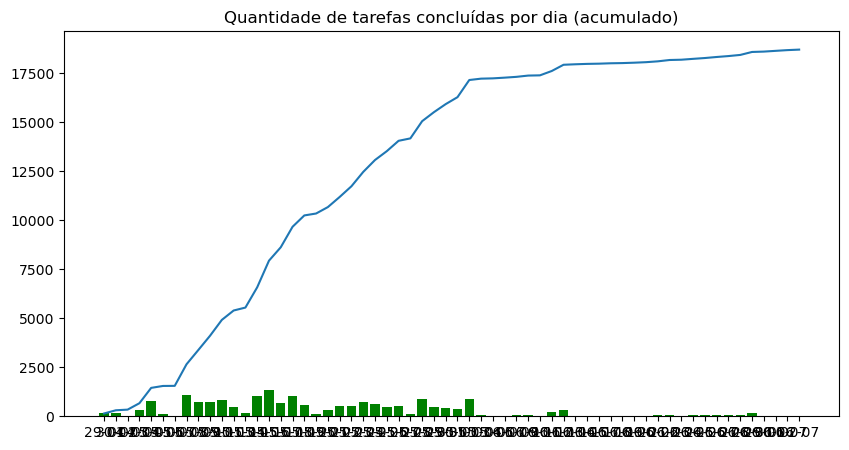

In [44]:
df_closed_on_date = df_labels[~df_labels['closed_on'].isna()][['closed_on','id']]
df_closed_on_date['closed_on'] = df_closed_on_date['closed_on'].dt.date
df_closed_on_date = df_closed_on_date.groupby('closed_on',as_index=False).count()
df_closed_on_date['acc'] = df_closed_on_date['id'].cumsum()

date = df_closed_on_date.iloc[:,0].values
date = df_closed_on_date.iloc[:,0].apply(lambda x: x.strftime('%d-%m'))

closed = df_closed_on_date.iloc[:,1].values
closed_acc = df_closed_on_date.iloc[:,2].values


fig,ax = plt.subplots(figsize=(10,5))
ax.plot(date,closed_acc)
ax.bar(date,closed,color='green')
ax.set_title('Quantidade de tarefas concluídas por dia (acumulado)')
plt.show()

In [45]:
df_fiscal = df_labels[df_labels['assigned_to']!='Maxwel de Souza Freitas']
df_fiscal = df_fiscal.pivot_table(index=['assigned_to', 'Unidade de Lotação'],columns='status',values='id',aggfunc='count')
df_fiscal = df_fiscal.fillna(0).astype('int')
df_fiscal['% Conclusão'] = df_fiscal['Concluída']/(df_fiscal.sum(axis=1))*100
df_fiscal['% Conclusão'] = df_fiscal['% Conclusão'].round(1)
df_fiscal = df_fiscal.sort_values(by='% Conclusão',ascending=False)
df_fiscal = df_fiscal.reset_index()

df_fiscal.columns = ['Fiscal', 'Unidade de Lotação', 'Concluída', 'Aberta', '% Conclusão']
df_fiscal

,Fiscal,Unidade de Lotação,Concluída,Aberta,% Conclusão
0,Aécio Ramires de Mesquita,UO071,1024,0,100.0
1,João Luis Alves Tavares,UO021,1024,0,100.0
2,Sebastião Rangel do Nascimento Silva,UO062,1024,0,100.0
3,Romildo Ignácio de Almeida,UO021,1024,0,100.0
4,Rafael Sales Dias,GR04,1024,0,100.0
5,Pedro de Barros,GR07,1024,0,100.0
6,Oppenheimer Herbert Hans Medeiros Queiroz,UO112,1024,0,100.0
7,Marcos Rogerio Gianotto,UO072,1024,0,100.0
8,Marcelo Ricardo Loschi,GR04,1024,0,100.0
9,Williams Roosevelt Monjardim,UO021,1024,0,100.0


In [46]:
df_fiscal[df_fiscal['% Conclusão']<20]

,Fiscal,Unidade de Lotação,Concluída,Aberta,% Conclusão
19,Leandro Rodrigues Belo,GR07,5,1019,0.5
20,Wesley Souza Chaves,GR07,1,1023,0.1


In [47]:
df_fiscal[df_fiscal['Unidade de Lotação']=='GR04']

,Fiscal,Unidade de Lotação,Concluída,Aberta,% Conclusão
4,Rafael Sales Dias,GR04,1024,0,100.0
8,Marcelo Ricardo Loschi,GR04,1024,0,100.0
12,José Carlos da Silva,GR04,1024,0,100.0


In [16]:
df_unidade = df_labels[df_labels['assigned_to']!='Maxwel de Souza Freitas']
df_unidade = df_labels.pivot_table(index='Unidade de Lotação',columns='status',values='id',aggfunc='count')
df_unidade = df_unidade.fillna(0).astype('int')
df_unidade['% Conclusão'] = df_unidade['Concluída']/(df_unidade.sum(axis=1))*100
df_unidade['% Conclusão'] = df_unidade['% Conclusão'].round(1)
df_unidade = df_unidade.sort_values(by='% Conclusão',ascending=False)
df_unidade = df_unidade.reset_index()
df_unidade.columns = ['Unidade', 'Concluída', 'Aberta', '% Conclusão']
df_unidade

,Unidade,Concluída,Aberta,% Conclusão
0,FIGF,1024,0,100.0
1,GR02,1024,0,100.0
2,GR06,1024,0,100.0
3,GR09,1024,0,100.0
4,UO062,1024,0,100.0
5,UO071,1024,0,100.0
6,UO072,1024,0,100.0
7,UO073,1024,0,100.0
8,UO112,1024,0,100.0
9,UO021,4103,5,99.9


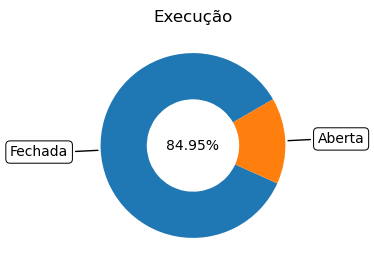

In [17]:
df_count = df_labels[['status','id']].groupby('status').count()
labels = [map_status[label] for label in df_count.index.values]
values = df_count.values.squeeze()
plot_donut(labels,values,'Execução',startangle=30)

In [18]:
with pd.ExcelWriter(FILE_RESULTS_REPORT) as writer:
    df_unidade.to_excel(writer, sheet_name='Unidade', index=False)
    df_fiscal.to_excel(writer, sheet_name='Fiscal', index=False)

## Preenchimento

Verificar se há incoerências no preenchimento, em especial nas perguntas sobre descrição. O campo do Fiscaliza que contém os dados do anúncio é denominado "Descrição" e pode confundir os fiscais durante a rotulagem.



In [48]:
df_labels[((df_labels['desc']==' ')
           &(df_labels['status']=='Concluída'))].pivot_table(
    index='Descrição identifica produto?',
    columns='Descrição bem elaborada?',
    values='id',aggfunc='count').fillna(0).astype('int')

Descrição bem elaborada?,Anúncio não possui descrição,Não,Sim
Descrição identifica produto?,,,
Anúncio não possui descrição,7109,14,6
Não,0,1,0
Sim,0,0,3


In [20]:
# df = df_labels[((df_labels['desc']==' ')
#            &(df_labels['status']=='Concluída')
#            &(df_labels['Descrição bem elaborada?']=='Anúncio não possui descrição')
#            &(df_labels['Descrição identifica produto?'].isin(['Sim','Não'])))]
# for id in df.id:
#     print(f'https://sistemas.anatel.gov.br/fiscaliza/issues/{id}')

In [21]:
# df = df_labels[((df_labels['desc']==' ')
#            &(df_labels['status']=='Concluída')
#            &(df_labels['Descrição bem elaborada?'].isin(['Sim','Não']))
#            &(df_labels['Descrição identifica produto?'].isin(['Sim','Não'])))]
# for id in tqdm(df.id):
#     custom_fields = [{'id': 2157, 'value': 'Anúncio não possui descrição'}, {'id': 2158, 'value': 'Anúncio não possui descrição'}]
#     _=redmine.issue.update(id,custom_fields=custom_fields)
# for id in df.id.sample(10):
#     print(f'https://sistemas.anatel.gov.br/fiscaliza/issues/{id}')
# df

In [22]:
# df = df_labels[((df_labels['É passível homologação?']=='Não')
#                 &(df_labels['É transmissor de RF'].isin(['Sim','Não é possível afirmar'])))]
# df

In [23]:
# df.shape

In [24]:
# for id in df.id:
#     print(f'https://sistemas.anatel.gov.br/fiscaliza/issues/{id}')

## Resultados da rotulagem

In [25]:
columns_to_keep = ['id', 'nome', 'desc', 
                   'Título bem elaborado?', 'Título identifica o produto?',
                   'Descrição bem elaborada?', 'Descrição identifica produto?',
                   'É passível homologação?', 'É transmissor de RF', 'Qual o tipo do produto?']
df_items = df_labels[df_labels['status']=='Concluída'][columns_to_keep]
df_items = df_items.reset_index(drop=True)

map_columns = {'id': 'id', 'nome': 'nome', 'desc': 'desc', 
               'Título bem elaborado?': 'titulo_bem_elaborado', 'Título identifica o produto?': 'titulo_identifica_produto',
               'Descrição bem elaborada?': 'desc_bem_elaborada', 'Descrição identifica produto?': 'desc_identifica_produto',
               'É passível homologação?': 'passivel_homologacao', 'É transmissor de RF': 'transmissor_rf', 'Qual o tipo do produto?': 'tipo_produto'}
df_items.columns = df_items.columns.map(map_columns)

map_labels = {'Não': 0, 'Sim': 1, 'Não é possível afirmar': 3, 'Anúncio não possui descrição': 3}

df_items['titulo_bem_elaborado'] = df_items['titulo_bem_elaborado'].astype('int')
df_items['titulo_identifica_produto'] = df_items['titulo_identifica_produto'].astype('int')

df_items['desc_bem_elaborada'] = df_items['desc_bem_elaborada'].map(map_labels)
df_items['desc_identifica_produto'] = df_items['desc_identifica_produto'].map(map_labels)

df_items['passivel_homologacao'] = df_items['passivel_homologacao'].map(map_labels)
df_items['transmissor_rf'] = df_items['transmissor_rf'].map(map_labels)

df_items.to_parquet(FILE_ITEMS)

df_items

,id,nome,desc,titulo_bem_elaborado,titulo_identifica_produto,desc_bem_elaborada,desc_identifica_produto,passivel_homologacao,transmissor_rf,tipo_produto
0,125728,Streaming Box S Tucson 2018 A 2022 Carplay 4g ...,STREAMING BOX S - 2GB RAM | 32GB ARMAZENAMENTO...,1,1,1,1,1,1,TV Box/TV Stick
1,125729,Smartphone Motorola Moto G52 XT2221-1 Dual Sim...,Fotografia profissional no seu bolsoDescubra i...,1,1,1,1,1,1,Smartphones
2,125730,Notebook Dell Latitude 7490 I5 8ª Ger Ddr4 16g...,Os produtos da Dell destacam-se por oferecer s...,1,1,1,1,1,1,Computador ou notebook
3,125731,"Mini rede sem fio, placa de rede sem fio USB 3...",,1,1,3,3,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)
4,125732,"Fone Bluetooth TWS Kaidi KD-771 - 5.1, Touch, ...","Fone Bluetooth Tws, Kaidi Kd-771, Bluetooth 5....",1,1,1,1,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)
...,...,...,...,...,...,...,...,...,...,...
18272,125715,CAIXA ACUSTICA PCX6500,,0,1,3,3,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)
18273,125716,Conector de cauda de celular 10 pcs carregando...,"[De alta qualidade] 100% nova fábrica, segura...",1,1,1,1,0,0,Outro tipo/categoria (não listada acima)
18274,125717,Avantree Medley Clear - Fones de ouvido sem fi...,,1,1,3,3,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)
18275,125718,"Hilitand Adaptador sem fio, placa de rede sem ...",,1,1,3,3,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)


In [26]:
# for id in df_items[df_items['tipo_produto']=='Bloqueador de sinal de celular (jammer/FlipperZero)'].id:
#     # for id in df.id.sample(10):
#     print(f'https://sistemas.anatel.gov.br/fiscaliza/issues/{id}')

In [27]:
# df_items.pivot_table(index='titulo_bem_elaborado', columns='titulo_identifica_produto', values='id', aggfunc='count')

In [28]:
# df_items.pivot_table(index='transmissor_rf', columns='passivel_homologacao', values='id', aggfunc='count').fillna(0).astype('int')

In [29]:
df_resumo_tipo = df_items.pivot_table(index='tipo_produto',columns=['passivel_homologacao','transmissor_rf'],values='id',aggfunc='count').fillna(0).astype('int')
df_resumo_tipo['total'] = df_resumo_tipo.sum(axis=1)
df_resumo_tipo = df_resumo_tipo.sort_values(by='total',ascending=False)

df_resumo_tipo

passivel_homologacao                                   0        1            \
transmissor_rf                                         0  1     0     1   3   
tipo_produto                                                                  
Outro tipo/categoria (não listada acima)            6336  1   338   834  33   
Transceptor de radiação restrita (2.4GHz/5.8GHz)      18  0    22  3369   1   
Não é possível afirmar                               469  0     2    69   5   
Carregador para celular (inclusive powerbank)         14  0  1045   253   8   
Smartphones                                            1  0    73  1054   0   
Drone                                                 13  0    41   685   0   
Transceptor de radiofrequência (VHF/UHF)               1  0     0   445   0   
Roteador/repetidor/reforçador WiFi (2.4GHz/5.8GHz)     0  0     2   441   0   
Bateria de lítio para celular                         26  0   330    54   0   
TV Box/TV Stick                                        4  0    21   224   2   
Carregador ou fonte não destinada a celular          182  0    36     8   1   
Bateria não destinada a celular                      116  0    15    11   1   
Computador ou notebook                                 3  0    12    82   1   
Peça ou acessório com fio para computador             66  0     4     6   0   
Reforçador/repetidor de sinal de celular (2G/3G...     0  0     0    40   0   
Modem celular (2G/3G/4G/5G)                            0  0     0    38   0   
Bloqueador de sinal de celular (jammer/FlipperZ...     0  0     0     1   0   

passivel_homologacao                                 3         total  
transmissor_rf                                       0  1    3        
tipo_produto                                                          
Outro tipo/categoria (não listada acima)            32  4  431  8009  
Transceptor de radiação restrita (2.4GHz/5.8GHz)     0  7    2  3419  
Não é possível afirmar                              23  3  866  1437  
Carregador para celular (inclusive powerbank)        5  0    3  1328  
Smartphones                                          0  2    0  1130  
Drone                                                1  2    3   745  
Transceptor de radiofrequência (VHF/UHF)             0  0    2   448  
Roteador/repetidor/reforçador WiFi (2.4GHz/5.8GHz)   0  3    0   446  
Bateria de lítio para celular                        1  1    0   412  
TV Box/TV Stick                                      0  0    5   256  
Carregador ou fonte não destinada a celular          3  0    6   236  
Bateria não destinada a celular                      2  0    6   151  
Computador ou notebook                               0  0    4   102  
Peça ou acessório com fio para computador            0  0    1    77  
Reforçador/repetidor de sinal de celular (2G/3G...   0  1    1    42  
Modem celular (2G/3G/4G/5G)                          0  0    0    38  
Bloqueador de sinal de celular (jammer/FlipperZ...   0  0    0     1

### Títulos

In [30]:
df_items['doc'] = df_items['nome'].map(clean_text)
df_items['tokens'] = df_items['nome'].apply(lambda doc: clean_text(doc, return_tokens=True))
df_items

,id,nome,desc,titulo_bem_elaborado,titulo_identifica_produto,desc_bem_elaborada,desc_identifica_produto,passivel_homologacao,transmissor_rf,tipo_produto,doc,tokens
0,125728,Streaming Box S Tucson 2018 A 2022 Carplay 4g ...,STREAMING BOX S - 2GB RAM | 32GB ARMAZENAMENTO...,1,1,1,1,1,1,TV Box/TV Stick,streaming box tucson 2018 2022 carplay 4g wi-f...,"[streaming, box, tucson, 2018, 2022, carplay, ..."
1,125729,Smartphone Motorola Moto G52 XT2221-1 Dual Sim...,Fotografia profissional no seu bolsoDescubra i...,1,1,1,1,1,1,Smartphones,smartphone motorola moto g52 xt2221-1 dual sim...,"[smartphone, motorola, moto, g52, xt2221-1, du..."
2,125730,Notebook Dell Latitude 7490 I5 8ª Ger Ddr4 16g...,Os produtos da Dell destacam-se por oferecer s...,1,1,1,1,1,1,Computador ou notebook,notebook dell latitude 7490 i5 8a ger ddr4 16g...,"[notebook, dell, latitude, 7490, i5, 8a, ger, ..."
3,125731,"Mini rede sem fio, placa de rede sem fio USB 3...",,1,1,3,3,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),mini rede fio placa rede fio usb 3.0 adaptador...,"[mini, rede, fio, placa, rede, fio, usb, 3.0, ..."
4,125732,"Fone Bluetooth TWS Kaidi KD-771 - 5.1, Touch, ...","Fone Bluetooth Tws, Kaidi Kd-771, Bluetooth 5....",1,1,1,1,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),fone bluetooth tws kaidi kd-771 5.1 touch prov...,"[fone, bluetooth, tws, kaidi, kd-771, 5.1, tou..."
...,...,...,...,...,...,...,...,...,...,...,...,...
18272,125715,CAIXA ACUSTICA PCX6500,,0,1,3,3,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),caixa acustica pcx6500,"[caixa, acustica, pcx6500]"
18273,125716,Conector de cauda de celular 10 pcs carregando...,"[De alta qualidade] 100% nova fábrica, segura...",1,1,1,1,0,0,Outro tipo/categoria (não listada acima),conector cauda celular 10 pcs carregando conec...,"[conector, cauda, celular, 10, pcs, carregando..."
18274,125717,Avantree Medley Clear - Fones de ouvido sem fi...,,1,1,3,3,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),avantree medley clear fones ouvido fio ouvir t...,"[avantree, medley, clear, fones, ouvido, fio, ..."
18275,125718,"Hilitand Adaptador sem fio, placa de rede sem ...",,1,1,3,3,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),hilitand adaptador fio placa rede fio adaptado...,"[hilitand, adaptador, fio, placa, rede, fio, a..."


### Bem elaborados x Mal elaborados

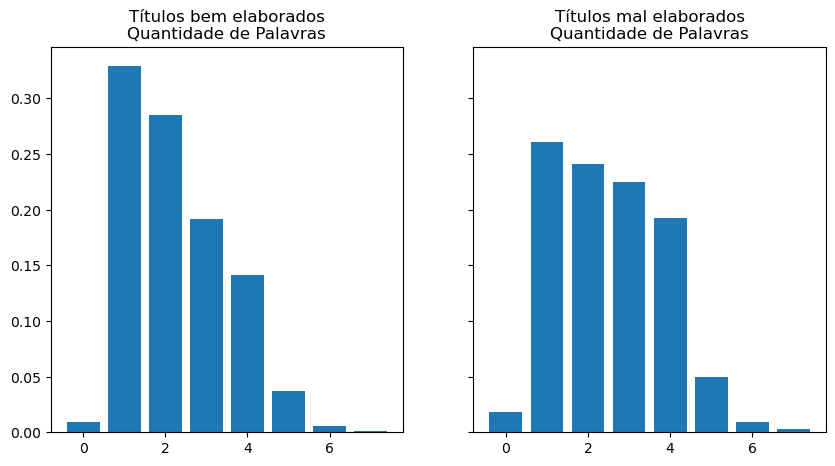

In [31]:
t_bem_elaborados = df_items[df_items['titulo_bem_elaborado']==1]['tokens']
t_mal_elaborados = df_items[df_items['titulo_bem_elaborado']==0]['tokens']

len_t_bem_elaborados = [len(doc) for doc in t_bem_elaborados]
len_t_mal_elaborados = [len(doc) for doc in t_mal_elaborados]

bins = [0,5,10,15,20,25,30,35,50]
h_len_t_bem_elaborados,_ = np.histogram(len_t_bem_elaborados,bins=bins)
h_len_t_mal_elaborados,_ = np.histogram(len_t_mal_elaborados,bins=bins)

h_len_t_bem_elaborados=h_len_t_bem_elaborados/h_len_t_bem_elaborados.sum()
h_len_t_mal_elaborados=h_len_t_mal_elaborados/h_len_t_mal_elaborados.sum()

fig,ax = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
x=range(len(bins)-1)
ax[0].bar(x,h_len_t_bem_elaborados)
ax[0].set_title('Títulos bem elaborados\nQuantidade de Palavras')
ax[1].bar(x,h_len_t_mal_elaborados)
ax[1].set_title('Títulos mal elaborados\nQuantidade de Palavras')

plt.show()

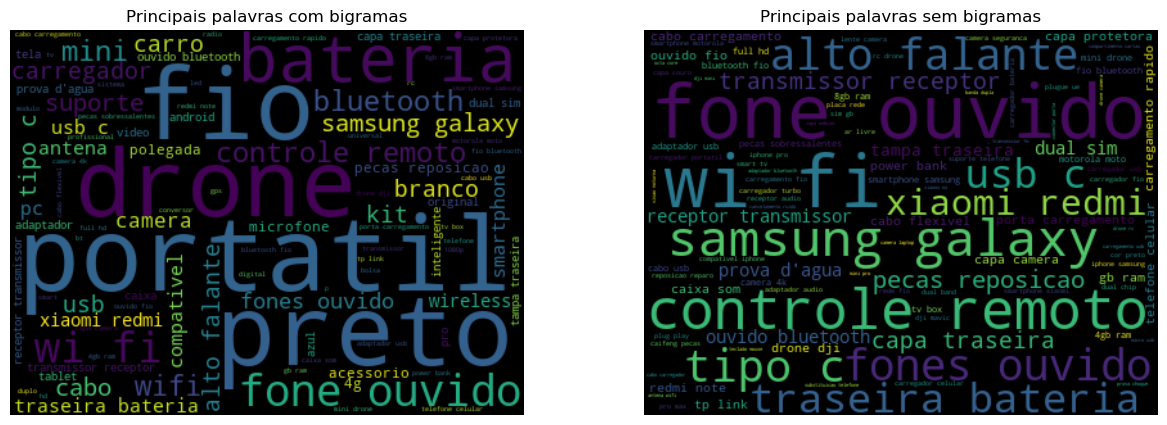

In [32]:
from functions import plot_wordcloud

f_t_bem_elaborados = [token for row in t_bem_elaborados for token in row]
f_t_mal_elaborados = [token for row in t_mal_elaborados for token in row]

plot_wordcloud(f_t_bem_elaborados,100)

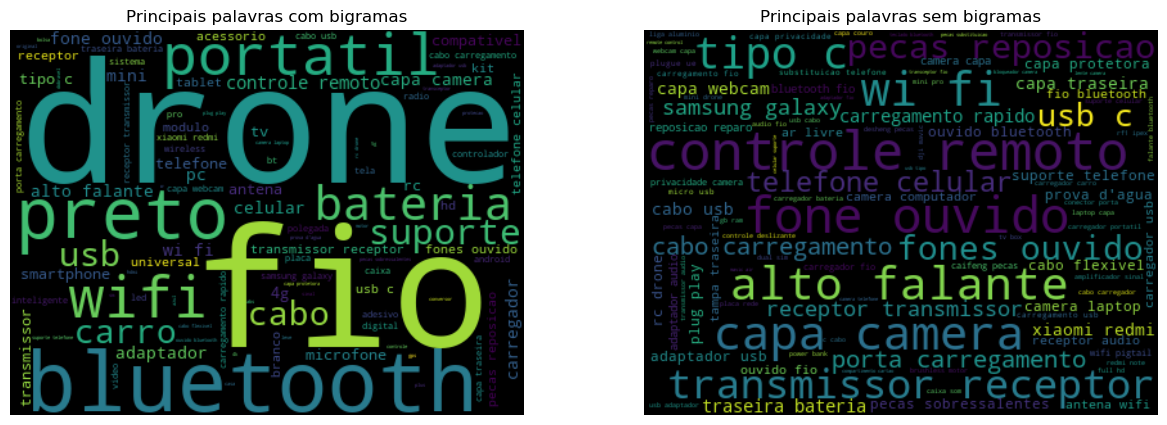

In [33]:
plot_wordcloud(f_t_mal_elaborados,100)

### Produtos passíveis de homologação vs não passíveis

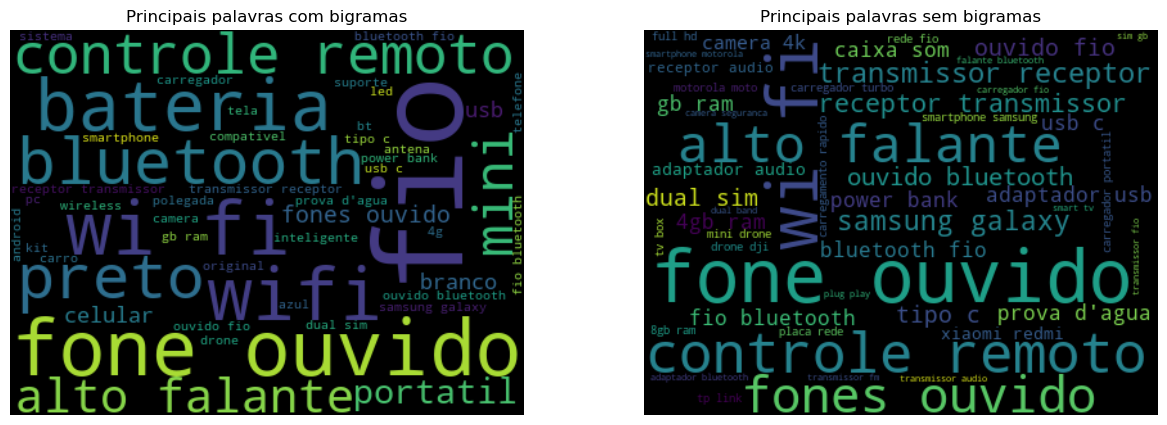

In [34]:
t_passiveis = df_items[df_items['passivel_homologacao']==1]['doc']
t_nao_passiveis = df_items[df_items['passivel_homologacao']==0]['doc']

plot_wordcloud(t_passiveis)

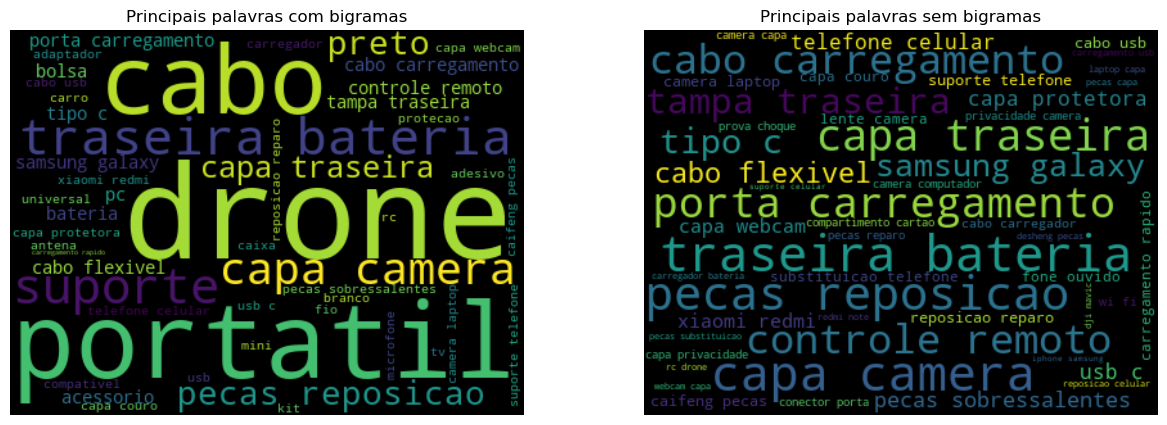

In [35]:
plot_wordcloud(t_nao_passiveis)

### Transmissores de rf vs não transmissores

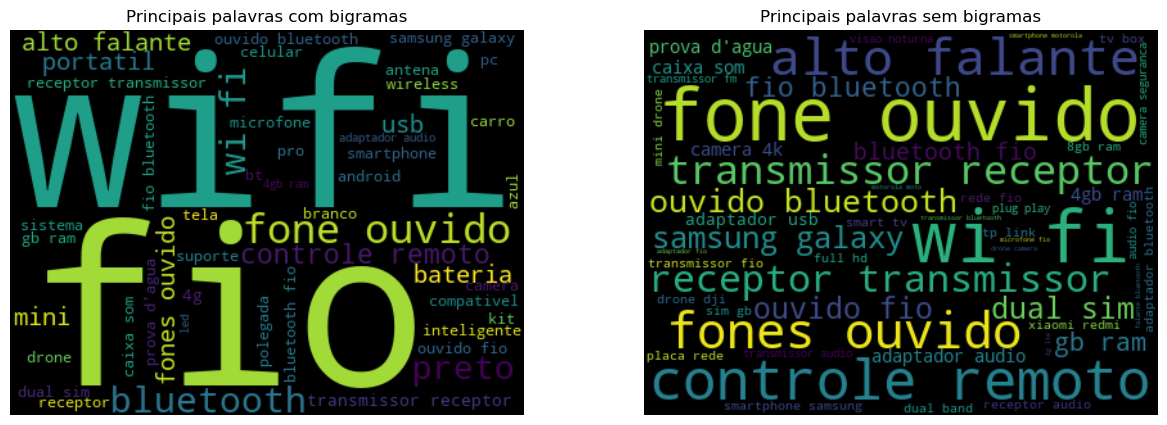

In [36]:
t_transmissor_rf = df_items[df_items['transmissor_rf']==1]['doc']
t_nao_transmissor_rf = df_items[df_items['transmissor_rf']==0]['doc']

plot_wordcloud(t_transmissor_rf)

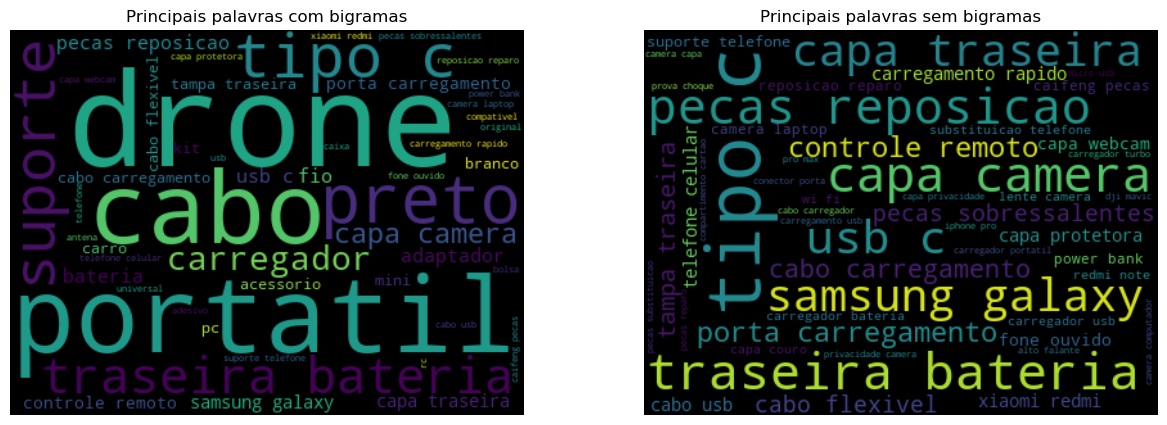

In [37]:
plot_wordcloud(t_nao_transmissor_rf)

# Atualizar Issues

In [38]:
# # redmine = Redmine(redmine_url,key=redmine_api_key)
# redmine = Redmine(redmine_url, username=username, password=password)

# open_issues = redmine.issue.filter(project_id=184, status_id='open')
# len(open_issues)

In [39]:
# for issue in open_issues[:10]:
#     print(issue['id'])

In [40]:
# open_issues = redmine.issue.filter(project_id=184, status_id='open')
# for issue in tqdm(open_issues[11:]):
#     id = issue['id']
#     redmine.issue.update(id,due_date='2024-06-30')

In [41]:
# open_issues = redmine.issue.filter(project_id=184, status_id='open')
# for issue in tqdm(open_issues[11:]):
#     print(issue['id'],issue['due_date'])